In [34]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from collections import defaultdict 
import jax
import flax
import chex
from jaxtyping import ArrayLike
from typing import Union, TypeVar
import numpy as np
import matplotlib.pyplot as plt

from tracr.compiler.validating import validate
from tracr.rasp.rasp import Map, SequenceMap, LinearSequenceMap, Select, Aggregate, Comparison, SelectorWidth, indices, tokens 
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.compiler.assemble import AssembledTransformerModel
from tracr.compiler.craft_model_to_transformer import NoTokensError
from tracr.compiler.basis_inference import InvalidValueSetError

from rasp_tokenizer import tokenizer
from rasp_tokenizer import vocab
from rasp_tokenizer.compiling import COMPILER_BOS
from rasp_generator.utils import sample_test_input, FunctionWithRepr
from rasp_generator import sampling, utils, map_primitives
from rasp_tokenizer.utils import RaspFlatDatapoint


rng = np.random.default_rng(0)

In [35]:
from time import time
import os
import pprint
import json
import pickle

import jax
import jax.numpy as jnp
from jax.typing import ArrayLike
import flax.linen as nn
import optax
import chex
from typing import Optional
from dataclasses import asdict
import numpy as np
import wandb
import argparse
from etils import epath
from tqdm import tqdm
import orbax.checkpoint
from etils import epath

from nn_utils import schedules
from meta_transformer import preprocessing, module_path, on_cluster, output_dir, interactive
from meta_transformer.meta_model import DecompilerModel, mup_adamw
from meta_transformer.train import Updater, Logger
from meta_transformer.logger_config import setup_logger
from meta_transformer.data import data_iterator
import meta_transformer.utils

from rasp_tokenizer import paths
from rasp_tokenizer import vocab
from rasp_tokenizer import tokenizer
from rasp_tokenizer.utils import RaspFlatDatapoint
from rasp_tokenizer.data_utils import load_data, process_data, split_dict_data

import rasp_tokenizer.utils


logger = setup_logger(__name__)

In [48]:
sampler = sampling.ProgramSampler()
sampler.sample()

nr sops: 22
Max sop program len: 17


In [49]:
utils.print_program(sampler.program)

map_235 = Map(lambda x: x != 4, indices)    # type: bool
select_242 = Select(indices, indices, predicate=Comparison.EQ)
select_234 = Select(tokens, tokens, predicate=Comparison.GEQ)
sequence_map_243 = SequenceMap(lambda x, y: x + y % 5, tokens, indices)    # type: categorical
aggregate_239 = Aggregate(select_242, indices)    # type: categorical
aggregate_232 = Aggregate(select_234, map_235)    # type: float
sequence_map_241 = SequenceMap(lambda x, y: x * (y + x) % 5, tokens, sequence_map_243)    # type: categorical
sequence_map_240 = SequenceMap(lambda x, y: x * y, tokens, sequence_map_241)    # type: categorical
sequence_map_238 = SequenceMap(lambda x, y: x * y, sequence_map_240, sequence_map_241)    # type: categorical
sequence_map_237 = SequenceMap(lambda x, y: x + y % 5, sequence_map_238, aggregate_239)    # type: categorical
select_236 = Select(indices, sequence_map_237, predicate=Comparison.TRUE)
aggregate_233 = Aggregate(select_236, map_235)    # type: float
linear_sequence_map_

In [3]:
data, test_data = load_data()

2024-01-27 16:55:30 [INFO]: Loading train/val data from /home/lauro/projects/meta-models/rasp-generator/scripts/data/train/small_data.pkl.
2024-01-27 16:55:30 [INFO]: Loading test data from /home/lauro/projects/meta-models/rasp-generator/scripts/data/test/50.pkl.


In [4]:
x = data[0]

In [5]:
x['rasp']

(1, 63, 6, 160, 166, 2, 1, 66, 9, 8, 63, 2)

In [28]:
from rasp_tokenizer.compiling import compile_rasp_to_model_and_return_graph


sop_1 = rasp.Map(FunctionWithRepr("lambda x: x + 1"), rasp.tokens)
sel = rasp.Select(sop_1, rasp.indices, rasp.Comparison.EQ)
program = rasp.SelectorWidth(sel)


#model, graph, sources = compile_rasp_to_model_and_return_graph(
#    program,
#    vocab={0,1,2,3,4},
#    max_seq_len=5,
#)

#graph = rasp_tokenizer.utils.add_variable_names_to_graph(graph)

In [29]:
model, tokens_by_layer, params_by_layer = tokenizer.compile_and_tokenize(
    program, 
    vocab={0,1,2,3,4},
    max_seq_len=5,
)

In [30]:
{k: tokenizer.decode(ts) for k, ts in tokens_by_layer.items()}

{'layer_0/attn': [],
 'layer_0/mlp': ['START',
  'SOp_0',
  'categorical',
  'Map',
  'lambda x: x + 1',
  'tokens',
  'END'],
 'layer_1/attn': ['START',
  'Selector_0',
  'Select',
  'EQ',
  'SOp_0',
  'indices',
  'END',
  'START',
  'Selector_1',
  'categorical',
  'SelectorWidth',
  'Selector_0',
  'END'],
 'layer_1/mlp': []}

In [45]:
rasp.Select??

Init signature:
rasp.Select(
    keys: tracr.rasp.rasp.SOp,
    queries: tracr.rasp.rasp.SOp,
    predicate: tracr.rasp.rasp.Predicate,
)
Source:        
class Select(Selector):
  """Primitive that creates a Selector."""

  def __init__(self, keys: SOp, queries: SOp, predicate: Predicate):
    super().__init__()
    self.keys = keys
    self.queries = queries
    self.predicate = predicate
    assert isinstance(self.keys, SOp)
    assert isinstance(self.queries, SOp)

  @property
  def children(self) -> Sequence[RASPExpr]:
    return [self.keys, self.queries]
File:           ~/projects/meta-models/tracr/tracr/rasp/rasp.py
Type:           ABCMeta
Subclasses:     

In [8]:
rasp_tokenizer.utils.get_args(graph, "select_2")

['EQ', 'tokens', 'indices']

In [42]:
graph.nodes

NodeView(('selector_width_6', 'select_7', 'map_8', 'indices', 'tokens'))

In [ ]:
# problems:
# - second sop arg missing from Select
# - sometimes Selector_n is arg to SequenceMap
# - sometimes SOp outputs are called 'Selector_n' (foe selectowidth ouputs)

In [41]:
tokenizer.decode(data[8]['rasp'])

['START',
 'Selector_0',
 'Select',
 'LT',
 'Selector_4',
 'Selector_5',
 'END',
 'START',
 'SOp_1',
 'categorical',
 'Aggregate',
 'Selector_0',
 'SOp_3',
 'END']

In [18]:
graph.nodes['select_2']

{'ID': 'select_2',
 'EXPR': <tracr.rasp.rasp.Select at 0x7efdee556440>,
 'token': 'Selector_0'}

In [21]:
rasp_tokenizer.utils.get_args(graph, "select_2")

['EQ', 'tokens', 'indices']

In [20]:
list(graph.predecessors('select_2'))

['tokens', 'indices']

In [10]:
tokenizer.decode(data[1]['rasp'])

['START', 'SOp_2', 'categorical', 'Map', 'lambda x: x + 2', 'tokens', 'END']

(array([9., 0., 0., 0., 0., 0., 0., 0., 6., 6., 0., 0., 0., 0., 1., 3., 4.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 0.        ,  0.83333333,  1.66666667,  2.5       ,  3.33333333,
         4.16666667,  5.        ,  5.83333333,  6.66666667,  7.5       ,
         8.33333333,  9.16666667, 10.        , 10.83333333, 11.66666667,
        12.5       , 13.33333333, 14.16666667, 15.        , 15.83333333,
        16.66666667, 17.5       , 18.33333333, 19.16666667, 20.        ,
        20.83333333, 21.66666667, 22.5       , 23.33333333, 24.16666667,
        25.        ]),
 <BarContainer object of 30 artists>)

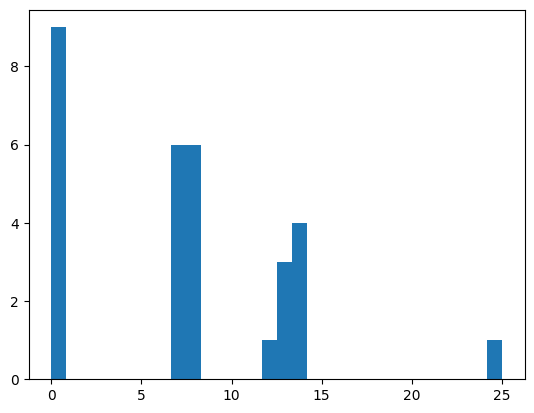

In [11]:
lengths = [len(x['rasp']) for x in data]
plt.hist(lengths, bins=30)

In [12]:
type(data)

list

In [13]:
type(data[0])

dict

In [14]:
x = data[0]

In [15]:
x['rasp']

(1, 63, 6, 160, 166, 2, 1, 66, 9, 8, 63, 2)

In [16]:
x['weights']

(0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0